In [19]:
import os
import json
import numpy as np
import pandas as pd
from time import time, strftime
from sklearn.metrics import precision_recall_fscore_support 
import pickle
def save_preds(preds, cb=False):
    preds = np.ravel(preds)
    assert len(preds)==338489
    avg = np.average(preds)
    std = np.std(preds)
    p = '../%s%s_dnn_tl_result_%.4f_%.4f_%s.csv' % ('callback_' if cb else '', 
        strftime('%H%M_%m%d'), avg, std, 'no_mess')

    df = pd.DataFrame({'instanceID': te_df_['instanceID'].values, 'proba': preds})
    df.sort_values('instanceID', inplace=True)
    df.to_csv(p, index=False)

    if cb: 
        print(' Written to: ', p)
        return avg, std
    else:
        print('\nTrain average: ', tr_avg)
        print('Preds average: ', avg)
        print('Preds std dev.: ', std)
        print('\nWritten to: ', p)

In [38]:
# data
# features = ['appCategory', 'positionID', 'positionType', 'creativeID', 'appID', 'adID',
#             'advertiserID', 'camgaignID', 'sitesetID', 'connectionType',
#             'residence', 'age', 'hometown', 'haveBaby', 'telecomsOperator',
#             'gender', 'education', 'clickTime_h', 'clickTime_d', 'weekDay',
#             'marriageStatus', 'appPlatform', 'clickTime_m', 'userID']

features = ['appCategory', 'positionID', 'positionType', 'creativeID', 'appID', 'adID',
            'advertiserID', 'camgaignID', 'sitesetID', 'connectionType',
            'residence', 'age', 'hometown', 'haveBaby', 'telecomsOperator',
            'gender', 'education', 'clickTime_h', 'clickTime_d', 'weekDay',
            'marriageStatus', 'appPlatform', 'clickTime_m', 'userID']
features.reverse()

tr_df = pd.read_csv('../data/pre/new_generated_train.csv', index_col=0)
te_df_ = pd.read_csv('../data/pre/new_generated_test.csv', index_col=0)
va_df = tr_df.loc[tr_df['clickTime_d'] == 24]

In [39]:
tr_df = tr_df[features+['label']]
va_df = va_df[features+['label']]
te_df = te_df_[features]
tr = tr_df.values
va = va_df.values
te = te_df.values
np.random.shuffle(tr)
tr_x, tr_y = tr[:, :-1], tr[:, -1:]
va_x, va_y = va[:, :-1], va[:, -1:]
tr_avg = np.average(tr_y)
max_f_cols = pd.concat([tr_df[features], te_df]).max().values+1
print(tr_df.columns.values, '\n', max_f_cols)

['userID' 'clickTime_m' 'appPlatform' 'marriageStatus' 'weekDay'
 'clickTime_d' 'clickTime_h' 'education' 'gender' 'telecomsOperator'
 'haveBaby' 'hometown' 'age' 'residence' 'connectionType' 'sitesetID'
 'camgaignID' 'advertiserID' 'adID' 'appID' 'creativeID' 'positionType'
 'positionID' 'appCategory' 'label'] 
 [2805119      60       3       4       8      32      24       8       3
       4       7    3402      81    3402       5       3     721      92
    3617     473    6583       6    7646     504]


In [ ]:
import xgboost as xgb
tr_y = np.ravel(tr_y)
gbm = xgb.XGBClassifier(max_depth=6, max_delta_step=1, silent=False, n_estimators=500, 
                        learning_rate=0.01, objective='binary:logistic', 
                       
                       ).fit(tr_x, tr_y, eval_set=[(va_x, va_y)], 
                        eval_metric='logloss', verbose=True)
predict_probas = gbm.predict_proba(te)[:,1]


/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-logloss:0.688418
[1]	validation_0-logloss:0.683715
[2]	validation_0-logloss:0.679036
[3]	validation_0-logloss:0.674382
[4]	validation_0-logloss:0.669754
[5]	validation_0-logloss:0.66515
[6]	validation_0-logloss:0.660571
[7]	validation_0-logloss:0.656017
[8]	validation_0-logloss:0.651489
[9]	validation_0-logloss:0.646985
[10]	validation_0-logloss:0.642506
[11]	validation_0-logloss:0.638052
[12]	validation_0-logloss:0.633623
[13]	validation_0-logloss:0.629219
[14]	validation_0-logloss:0.62484
[15]	validation_0-logloss:0.620486
[16]	validation_0-logloss:0.616157
[17]	validation_0-logloss:0.611853
[18]	validation_0-logloss:0.607573
[19]	validation_0-logloss:0.603318
[20]	validation_0-logloss:0.599088
[21]	validation_0-logloss:0.594883
[22]	validation_0-logloss:0.590702
[23]	validation_0-logloss:0.586546
[24]	validation_0-logloss:0.582415
[25]	validation_0-logloss:0.578308
[26]	validation_0-logloss:0.574226
[27]	validation_0-logloss:0.570168
[28]	validation_0-logloss:0.5661

In [42]:
va_y_pred = gbm.predict(va_x)
len(va_y_pred)

285242

In [43]:

# ====================================================================================== #
# save result
save_preds(predict_probas)

va_y_pred = (va_y_pred > .5).astype('int32')

p, r, f, _ = precision_recall_fscore_support(va_y, va_y_pred)

print('PRF: ', p,r,f)


Train average:  0.0248729973479
Preds average:  0.269132
Preds std dev.:  0.00292539

Written to:  ../1328_0527_dnn_tl_result_0.2691_0.0029_no_mess.csv
PRF:  [ 0.97412022  0.        ] [ 1.  0.] [ 0.98689047  0.        ]


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
va_y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

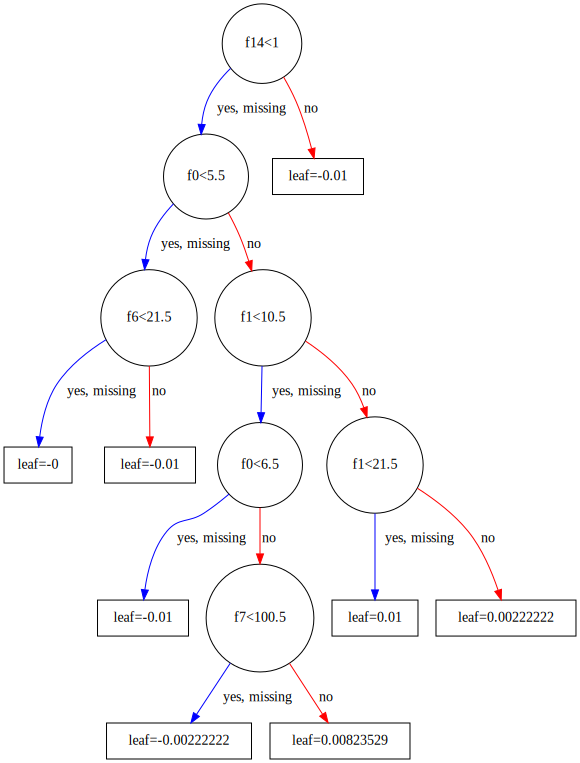

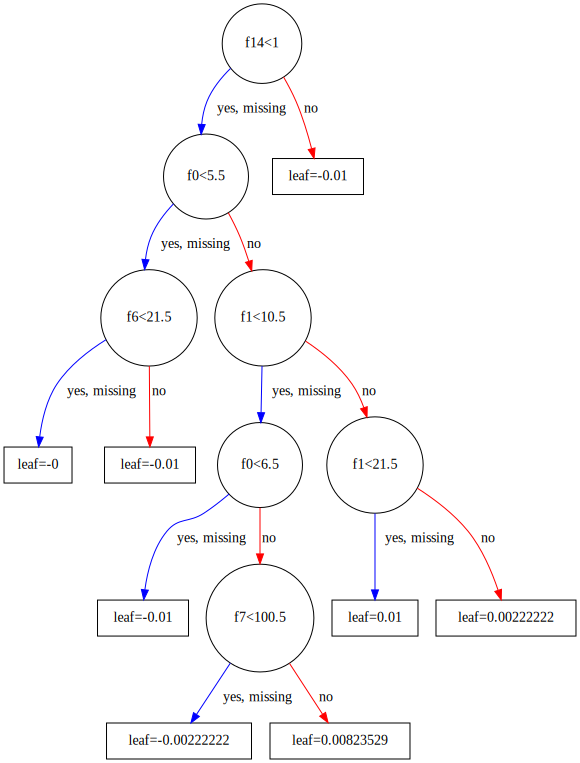

In [36]:
xgb.plot_importance(gbm)
xgb.to_graphviz(gbm)